In [1]:
# ref : https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons#Country-wise-Data

import random
from datetime import timedelta

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
# import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

# os
import os
for dirname, _, filenames in os.walk('/kaggle/input/coronavirusdataset/'):
    print('>>> files in', dirname)
    print('>>>', filenames)

>>> files in /kaggle/input/coronavirusdataset/
>>> ['PatientInfo.csv', 'Weather.csv', 'Case.csv', 'TimeGender.csv', 'TimeAge.csv', 'Time.csv', 'PatientRoute.csv', 'SeoulFloating.csv', 'Region.csv', 'TimeProvince.csv', 'SearchTrend.csv']


In [2]:
# 데이터 불러오기
TimeProvince_df = pd.read_csv('/kaggle/input/coronavirusdataset/TimeProvince.csv', parse_dates=['date'])


# 파생변수 생성 : 누적 확진자 수에서, 동일한 지역의 하루 전 누적 확진자 수를 뺀 new_comfirmed
tmp_df = TimeProvince_df[['province', 'date','confirmed']].rename(columns={'confirmed':'confirmed_D-1'})
tmp_df['date'] = tmp_df['date'] + timedelta(days=1)

TimeProvince_df = pd.merge(TimeProvince_df, tmp_df, how='left', on=['province', 'date'])
TimeProvince_df['confirmed_D-1'] = TimeProvince_df['confirmed_D-1'].fillna(0).astype(int)
TimeProvince_df['new_confirmed'] = TimeProvince_df['confirmed'] - TimeProvince_df['confirmed_D-1']


# 파생변수 생성 : active(격리중) = confirmed - deceased - released
TimeProvince_df['active'] = TimeProvince_df['confirmed'] - TimeProvince_df['deceased'] - TimeProvince_df['released']


TimeProvince_df.tail(5)

,date,time,province,confirmed,released,deceased,confirmed_D-1,new_confirmed,active
1338,2020-04-07,0,Jeollabuk-do,16,7,0,16,0,9
1339,2020-04-07,0,Jeollanam-do,15,4,0,15,0,11
1340,2020-04-07,0,Gyeongsangbuk-do,1317,934,46,1316,1,337
1341,2020-04-07,0,Gyeongsangnam-do,112,80,0,111,1,32
1342,2020-04-07,0,Jeju-do,12,4,0,12,0,8


In [3]:
# 지역명 한글화
cities_eng = TimeProvince_df.province.unique()
cities_kor = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주도']
cities_dict = dict(zip(cities_eng, cities_kor))
print(cities_dict)

{'Seoul': '서울', 'Busan': '부산', 'Daegu': '대구', 'Incheon': '인천', 'Gwangju': '광주', 'Daejeon': '대전', 'Ulsan': '울산', 'Sejong': '세종', 'Gyeonggi-do': '경기도', 'Gangwon-do': '강원도', 'Chungcheongbuk-do': '충청북도', 'Chungcheongnam-do': '충청남도', 'Jeollabuk-do': '전라북도', 'Jeollanam-do': '전라남도', 'Gyeongsangbuk-do': '경상북도', 'Gyeongsangnam-do': '경상남도', 'Jeju-do': '제주도'}


In [4]:
TimeProvince_df.province = TimeProvince_df.province.map(cities_dict)
TimeProvince_df.tail(5)

,date,time,province,confirmed,released,deceased,confirmed_D-1,new_confirmed,active
1338,2020-04-07,0,전라북도,16,7,0,16,0,9
1339,2020-04-07,0,전라남도,15,4,0,15,0,11
1340,2020-04-07,0,경상북도,1317,934,46,1316,1,337
1341,2020-04-07,0,경상남도,112,80,0,111,1,32
1342,2020-04-07,0,제주도,12,4,0,12,0,8


## 1. 지역별 확진자/완치자/사망자/격리자 현황

In [5]:
# 최신 날짜의 지역별 현황 출력(확진자 순으로 내림차순 정렬)
recent_df = TimeProvince_df[TimeProvince_df.date == TimeProvince_df.date.max()].sort_values(by='confirmed', ascending=False)
recent_df.style.background_gradient(cmap='Blues', subset=['confirmed']).\
                background_gradient(cmap="Greens", subset=['released']).\
                background_gradient(cmap="Reds", subset=['deceased']).\
                background_gradient(cmap="PuBu", subset=['active'])

,date,time,province,confirmed,released,deceased,confirmed_D-1,new_confirmed,active
1328,2020-04-07 00:00:00,0,대구,6794,4918,134,6781,13,1742
1340,2020-04-07 00:00:00,0,경상북도,1317,934,46,1316,1,337
1334,2020-04-07 00:00:00,0,경기도,590,226,7,580,10,357
1326,2020-04-07 00:00:00,0,서울,567,164,0,563,4,403
1337,2020-04-07 00:00:00,0,충청남도,137,104,0,136,1,33
1327,2020-04-07 00:00:00,0,부산,123,91,3,122,1,29
1341,2020-04-07 00:00:00,0,경상남도,112,80,0,111,1,32
1329,2020-04-07 00:00:00,0,인천,80,27,0,80,0,53
1335,2020-04-07 00:00:00,0,강원도,47,24,1,45,2,22
1333,2020-04-07 00:00:00,0,세종,46,17,0,46,0,29


## 2. 지역별 누적 확진자 추이 그래프 (50번째 확진자 발생 이후)

In [6]:
# ref : https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons/notebook

# 지역별 누적 확진자 추이 그래프(K번째 확진자 발생 이후) 함수 정의
def confirms_from_nth_confirm(df, nth_confirm_threshold):
    # 전처리 - 누적 확진자 K명 이상인 행만 추리고, 도시 별로 누적 확진자 K명 발생 이후 몇 일째인지 계산한 days_after_thresh 파생변수 생성
    over_threshold_df = df[ df['confirmed'] >= nth_confirm_threshold ]  # 사용할 행 추출
    over_threshold_df = over_threshold_df[['province', 'date', 'confirmed']].sort_values(['province','date'])  # 사용할 열 추출 후 정렬

    min_date = over_threshold_df.groupby('province')['date'].min().reset_index()  # 도시 별 누적 확진자 K명 발생 날짜 추출
    min_date_dict = dict(min_date.to_numpy())

    over_threshold_df['days_after_thresh'] = over_threshold_df.apply( lambda x : x.date - min_date_dict[x.province], axis=1).dt.days  # 파생변수 생성


    over_threshold_cities = over_threshold_df['province'].unique()  # 도시 수 확인
    print(f"누적 확진자 {nth_confirm_threshold}명 이상인 도시 ({len(over_threshold_cities)}개) : {', '.join(over_threshold_cities)}")


    # 시각화 - 도시 별 누적 확진자 K명 발생 이후 확진자 추이
    over_threshold_df = over_threshold_df.rename(columns={'confirmed': '확진자 수', 'province':'시/도', 'days_after_thresh':'기준일 이후 일수'})  # 컬럼명 한글화
    fig = px.line(over_threshold_df, x='기준일 이후 일수', y='확진자 수', color='시/도', title=f'시/도별 누적 확진자 추이 ({nth_confirm_threshold}번째 확진자 발생 이후)', height=800)
    fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
    pass


confirms_from_nth_confirm(TimeProvince_df, 50)

누적 확진자 50명 이상인 도시 (8개) : 경기도, 경상남도, 경상북도, 대구, 부산, 서울, 인천, 충청남도


In [7]:
# 대구, 경북 제외
temp_df = TimeProvince_df[(TimeProvince_df.province != '대구') & (TimeProvince_df.province != '경상북도')]
confirms_from_nth_confirm(temp_df, 50)

누적 확진자 50명 이상인 도시 (6개) : 경기도, 경상남도, 부산, 서울, 인천, 충청남도


## 3. 지역별 누적 완치자 추이 그래프 (50번째 확진자 발생 이후)

In [8]:
# 시/도별 누적 완치자 추이 그래프(K번째 확진자 발생 이후)
def releases_from_nth_confirm(df, nth_confirm_threshold):
    # 전처리 - 누적 확진자 K명 이상인 도시들만 추려서, 도시 별로 누적 확진자 K명 발생 이후 몇 일째인지 계산한 days_after_thresh 파생변수 생성
    over_threshold_df = df[ df['confirmed'] >= nth_confirm_threshold ]  # 사용할 행 추출
    over_threshold_df = over_threshold_df[['province', 'date', 'released']].sort_values(['province','date'])  # 사용할 열 추출 후 정렬

    min_date = over_threshold_df.groupby('province')['date'].min().reset_index()  # 도시 별 누적 확진자 K명 발생 날짜 추출
    min_date_dict = dict(min_date.to_numpy())

    over_threshold_df['days_after_thresh'] = over_threshold_df.apply( lambda x : x.date - min_date_dict[x.province], axis=1).dt.days  # 파생변수 생성


    over_threshold_cities = over_threshold_df['province'].unique()  # 도시 수 확인
    print(f"누적 확진자 {nth_confirm_threshold}명 이상인 도시 ({len(over_threshold_cities)}개) : {', '.join(over_threshold_cities)}")


    # 시각화 - 도시 별 누적 확진자 K명 발생 이후 확진자 추이
    over_threshold_df = over_threshold_df.rename(columns={'released': '완치자 수', 'province':'시/도', 'days_after_thresh':'기준일 이후 일수'})  # 컬럼명 한글화
    fig = px.line(over_threshold_df, x='기준일 이후 일수', y='완치자 수', color='시/도', title=f'시/도별 누적 완치자 추이 ({nth_confirm_threshold}번째 확진자 발생 이후)', height=800)
    fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
    pass


releases_from_nth_confirm(TimeProvince_df, 50)

누적 확진자 50명 이상인 도시 (8개) : 경기도, 경상남도, 경상북도, 대구, 부산, 서울, 인천, 충청남도


In [9]:
# 대구, 경북 제외
temp_df = TimeProvince_df[(TimeProvince_df.province != '대구') & (TimeProvince_df.province != '경상북도')]
releases_from_nth_confirm(temp_df, 50)

누적 확진자 50명 이상인 도시 (6개) : 경기도, 경상남도, 부산, 서울, 인천, 충청남도


## 4. 지역별 확진자 대비 완치자 추이(누적/일일)

In [10]:
# 나눔체 글꼴 설치 (한글폰트 깨지는 현상 해결)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 72030 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20140930-1_all.deb ...
Unpacking fonts-nanum (20140930-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20140930-1_all.deb ...
Unpacking fonts-nanum-extra (20140930-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.0-10_all.deb ...
Unpacking fonts-nanum-coding (2.0-10) ...
Setting up fonts-nanum-extra (20140930-1) ...
Setting up fonts-nanum (20140930-1) ...
Setting up fonts-nanum-coding (2.0-10) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.11.0-

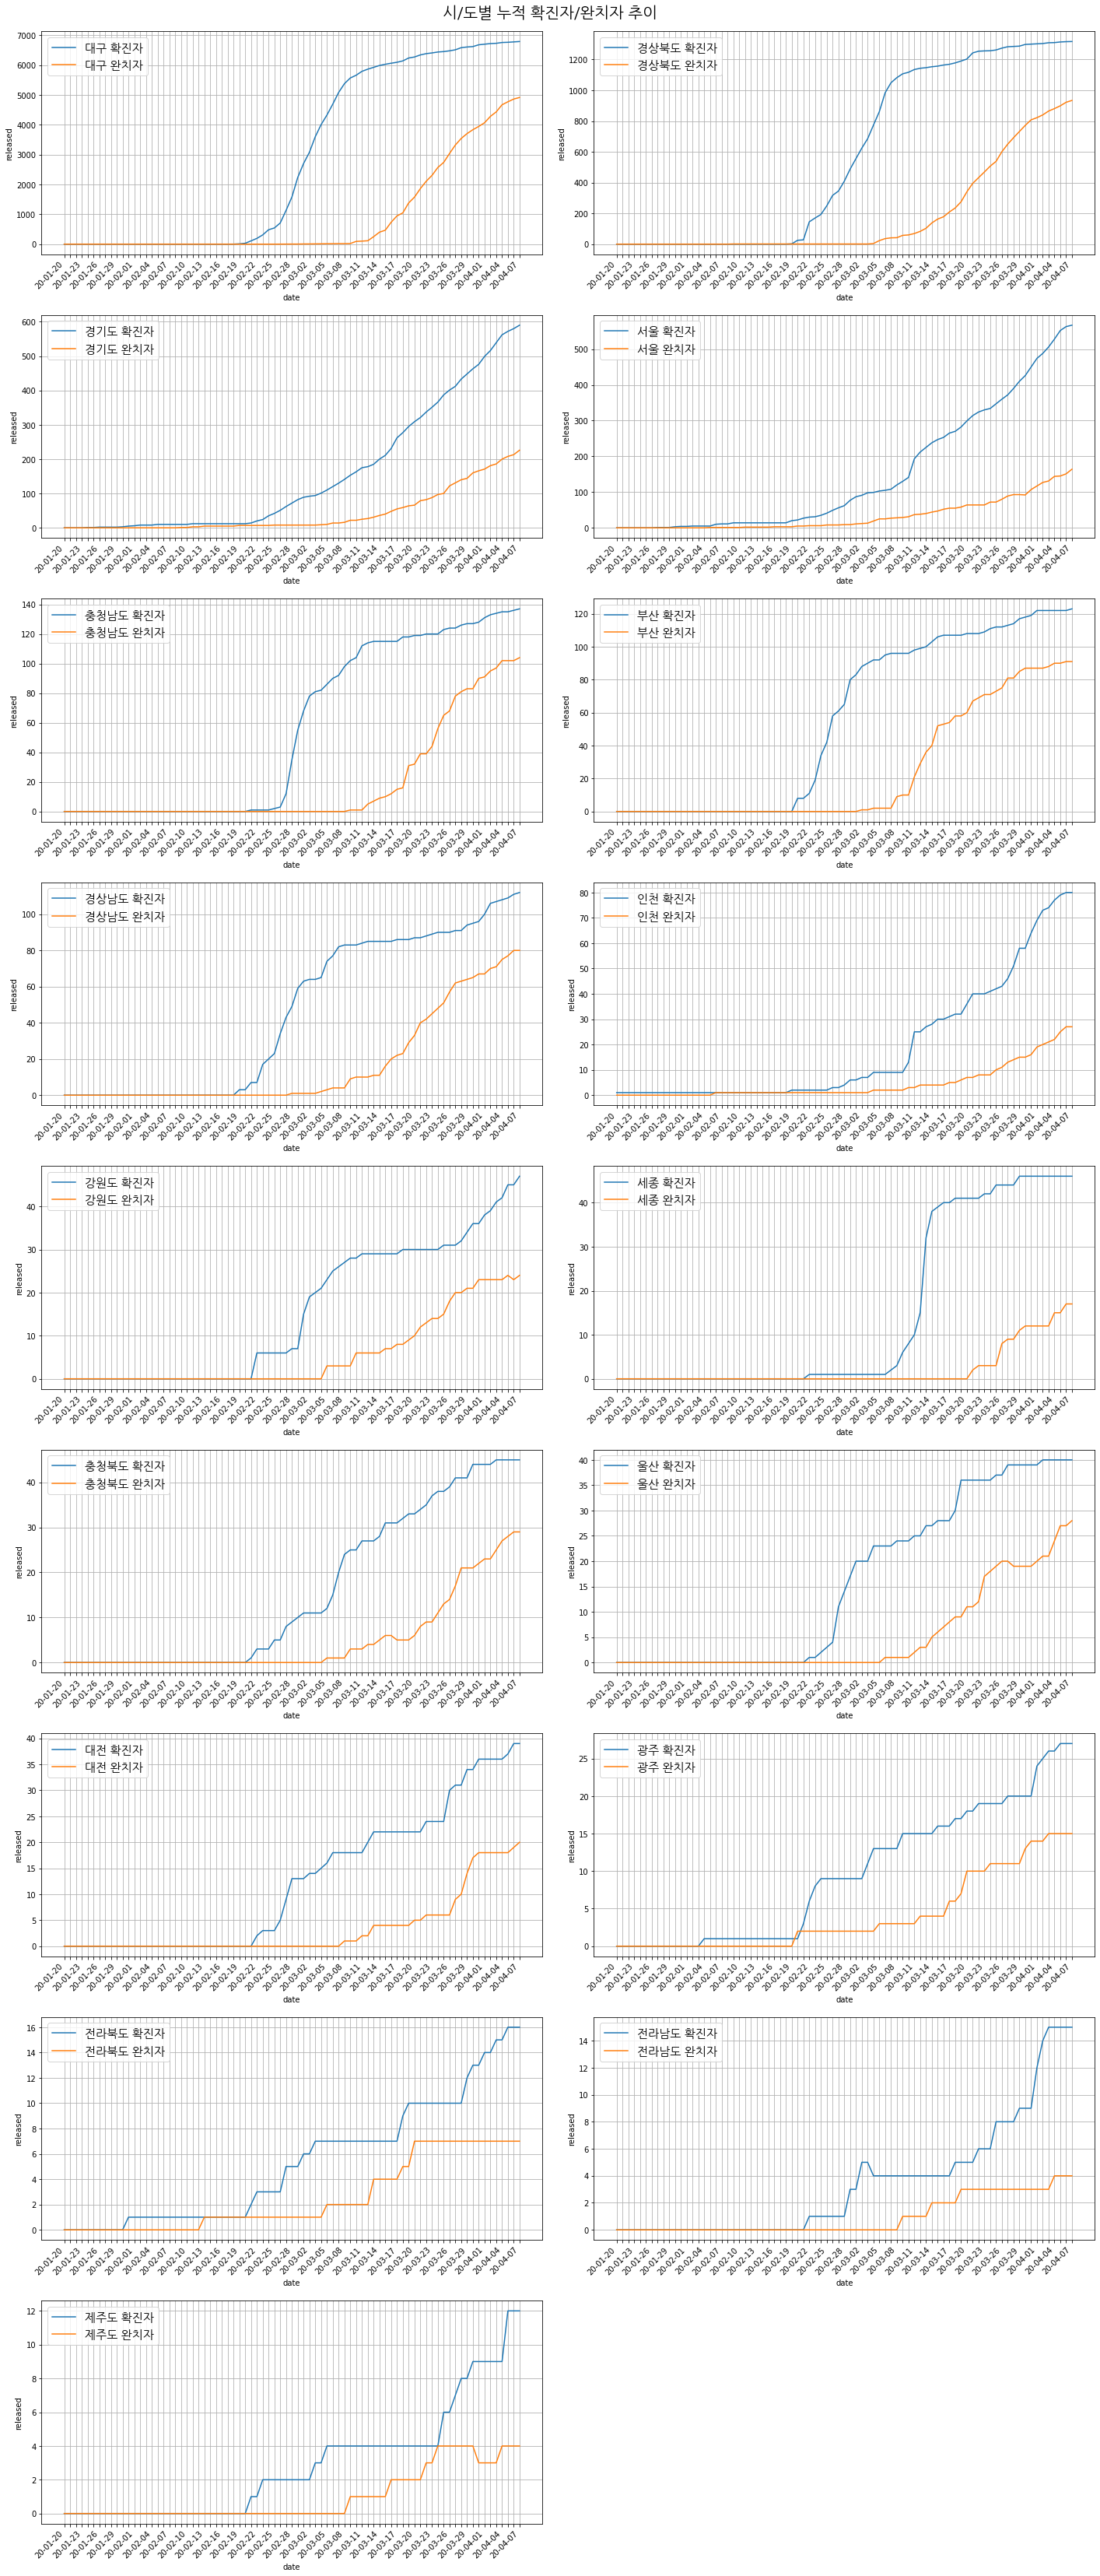

In [11]:
# 시/도별 누적 확진자/완치자 추이 그래프
font_path =  '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
cities = TimeProvince_df.sort_values('confirmed', ascending=False).province.unique()

fig = plt.figure(figsize=(20, 5*len(cities)//2 +5))
for idx, city in enumerate(cities):
    tmp_ax = plt.subplot(len(cities)//2 +1, 2, idx+1)
    tmp_df = TimeProvince_df[TimeProvince_df.province==city]
    
    sns.lineplot(tmp_df.date, tmp_df.confirmed, label=f'{city} 확진자', ax=tmp_ax)
    sns.lineplot(tmp_df.date, tmp_df.released, label=f'{city} 완치자', ax=tmp_ax)
    
    # x축 구간 및 라벨 설정
    plt.xticks(tmp_df.date, rotation=45, horizontalalignment='right')
    tmp_xticks_labels = [ date.strftime('%y-%m-%d') if idx%3==0 else '' for idx, date in enumerate(tmp_df.date) ]
    tmp_ax.set_xticklabels(tmp_xticks_labels)
    
    tmp_ax.legend(prop=fm.FontProperties(fname=font_path, size=15))
    plt.grid()
    pass

plt.suptitle('시/도별 누적 확진자/완치자 추이', fontproperties=fm.FontProperties(fname=font_path, size=20))
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.97)

plt.show()

## 5. 지역별 누적확진자 대비 일일 격리자 현황 추이

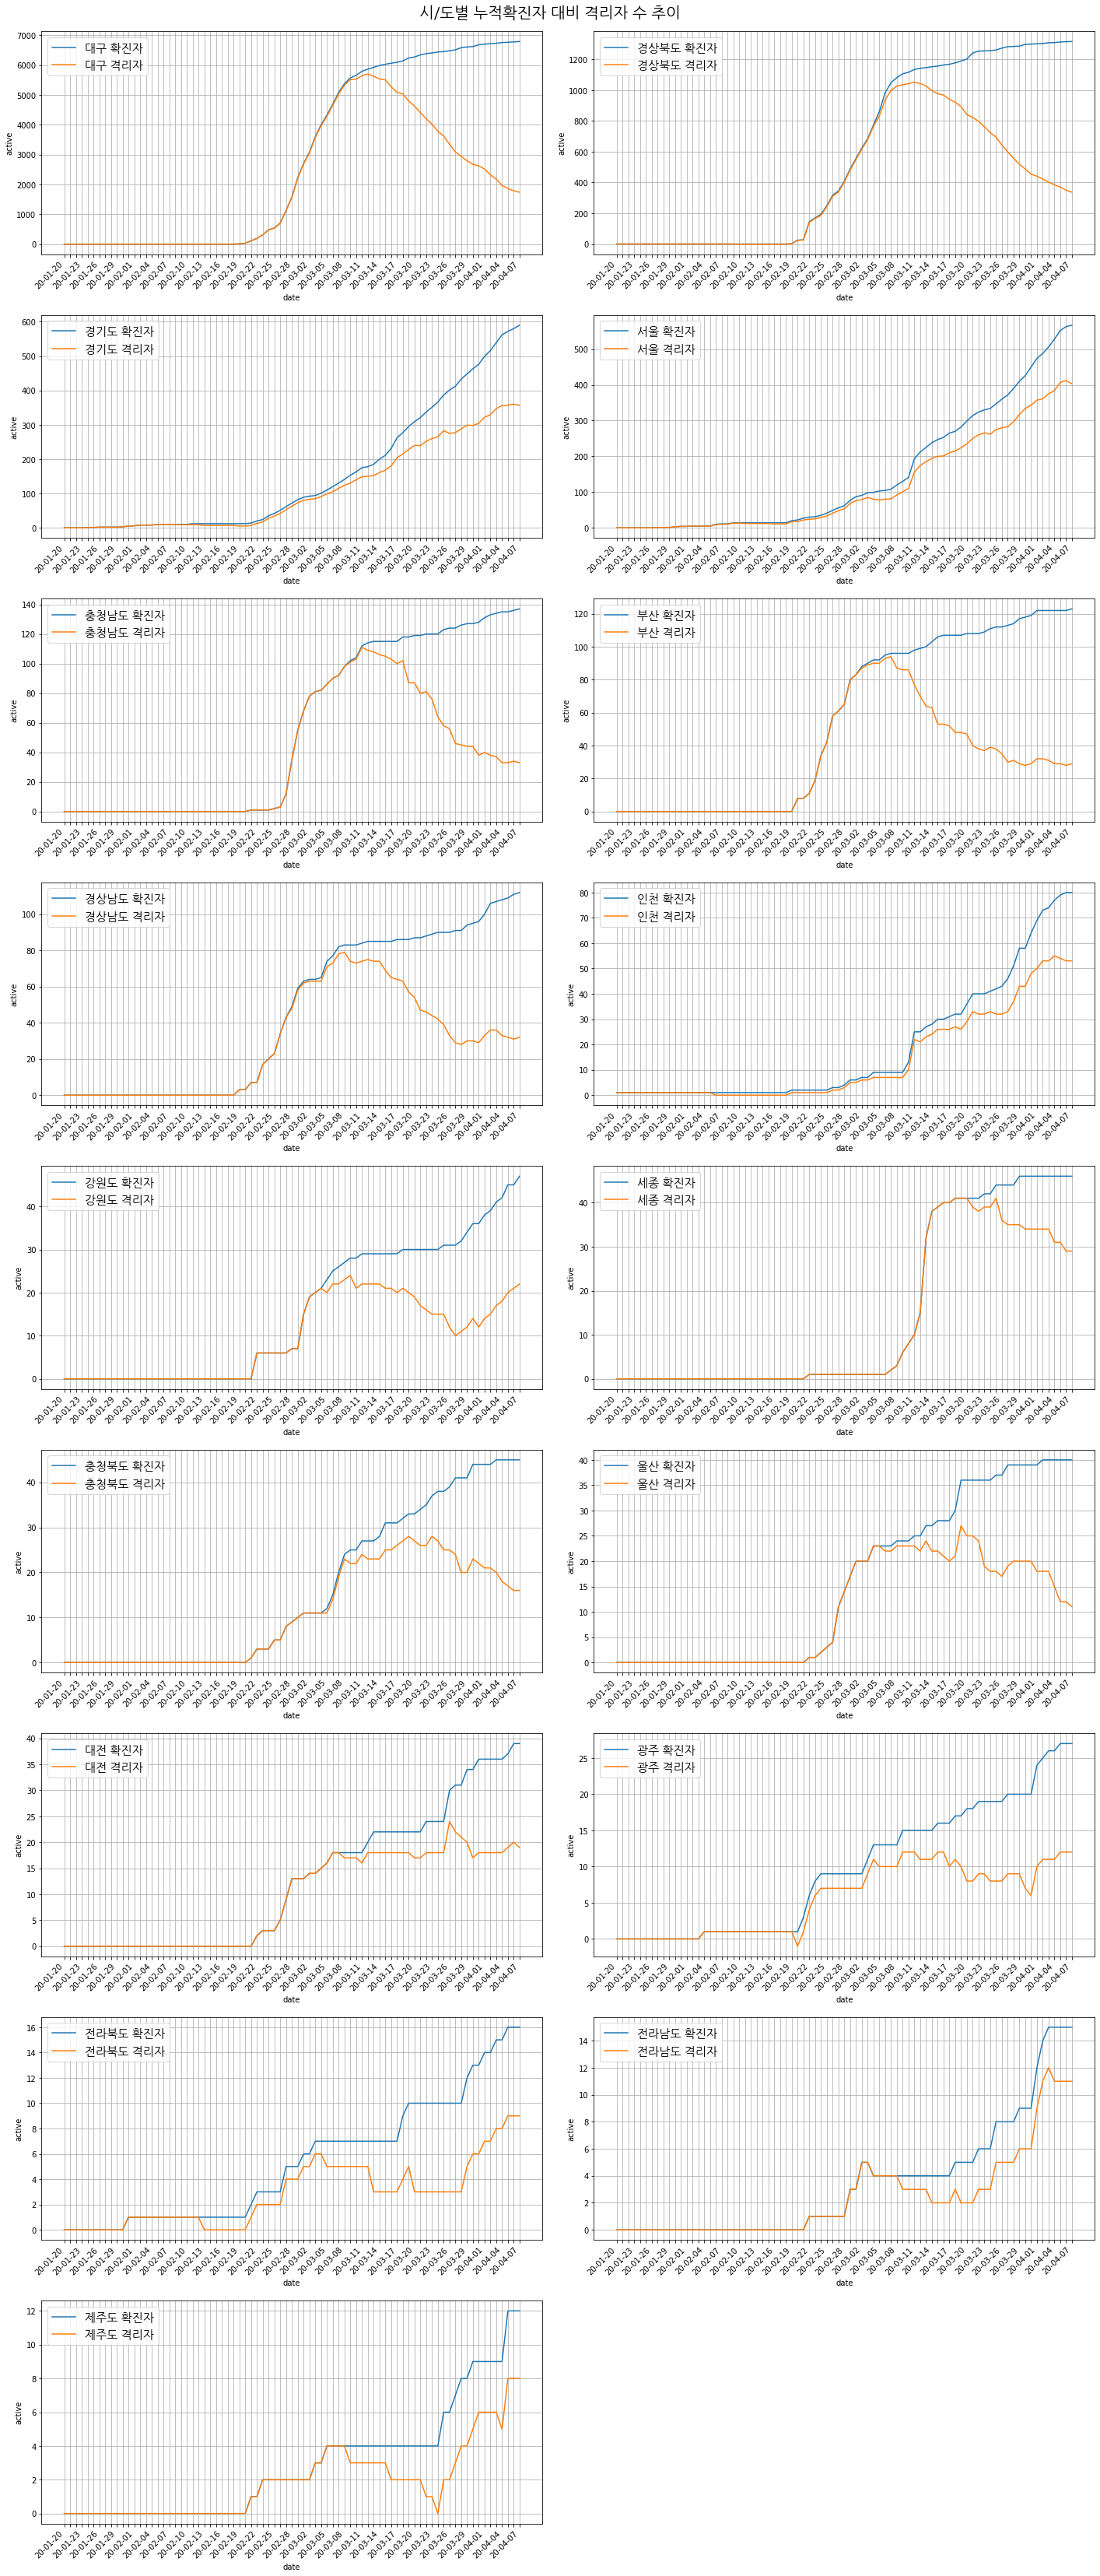

In [12]:
# 시/도별 누적확진자 대비 격리자 수 추이 그래프
font_path =  '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
cities = TimeProvince_df.sort_values('confirmed', ascending=False).province.unique()

fig = plt.figure(figsize=(20, 5*len(cities)//2 +5))
for idx, city in enumerate(cities):
    tmp_ax = plt.subplot(len(cities)//2 +1, 2, idx+1)
    tmp_df = TimeProvince_df[TimeProvince_df.province==city]
    
    sns.lineplot(tmp_df.date, tmp_df.confirmed, label=f'{city} 확진자', ax=tmp_ax)
    sns.lineplot(tmp_df.date, tmp_df.active, label=f'{city} 격리자', ax=tmp_ax)
    
    # x축 구간 및 라벨 설정
    plt.xticks(tmp_df.date, rotation=45, horizontalalignment='right')
    tmp_xticks_labels = [ date.strftime('%y-%m-%d') if idx%3==0 else '' for idx, date in enumerate(tmp_df.date) ]
    tmp_ax.set_xticklabels(tmp_xticks_labels)
    
    tmp_ax.legend(prop=fm.FontProperties(fname=font_path, size=15))
    plt.grid()
    pass

plt.suptitle('시/도별 누적확진자 대비 격리자 수 추이', fontproperties=fm.FontProperties(fname=font_path, size=20))
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.97)

plt.show()

## 6. 지역별 일일 신규 확진자 추이

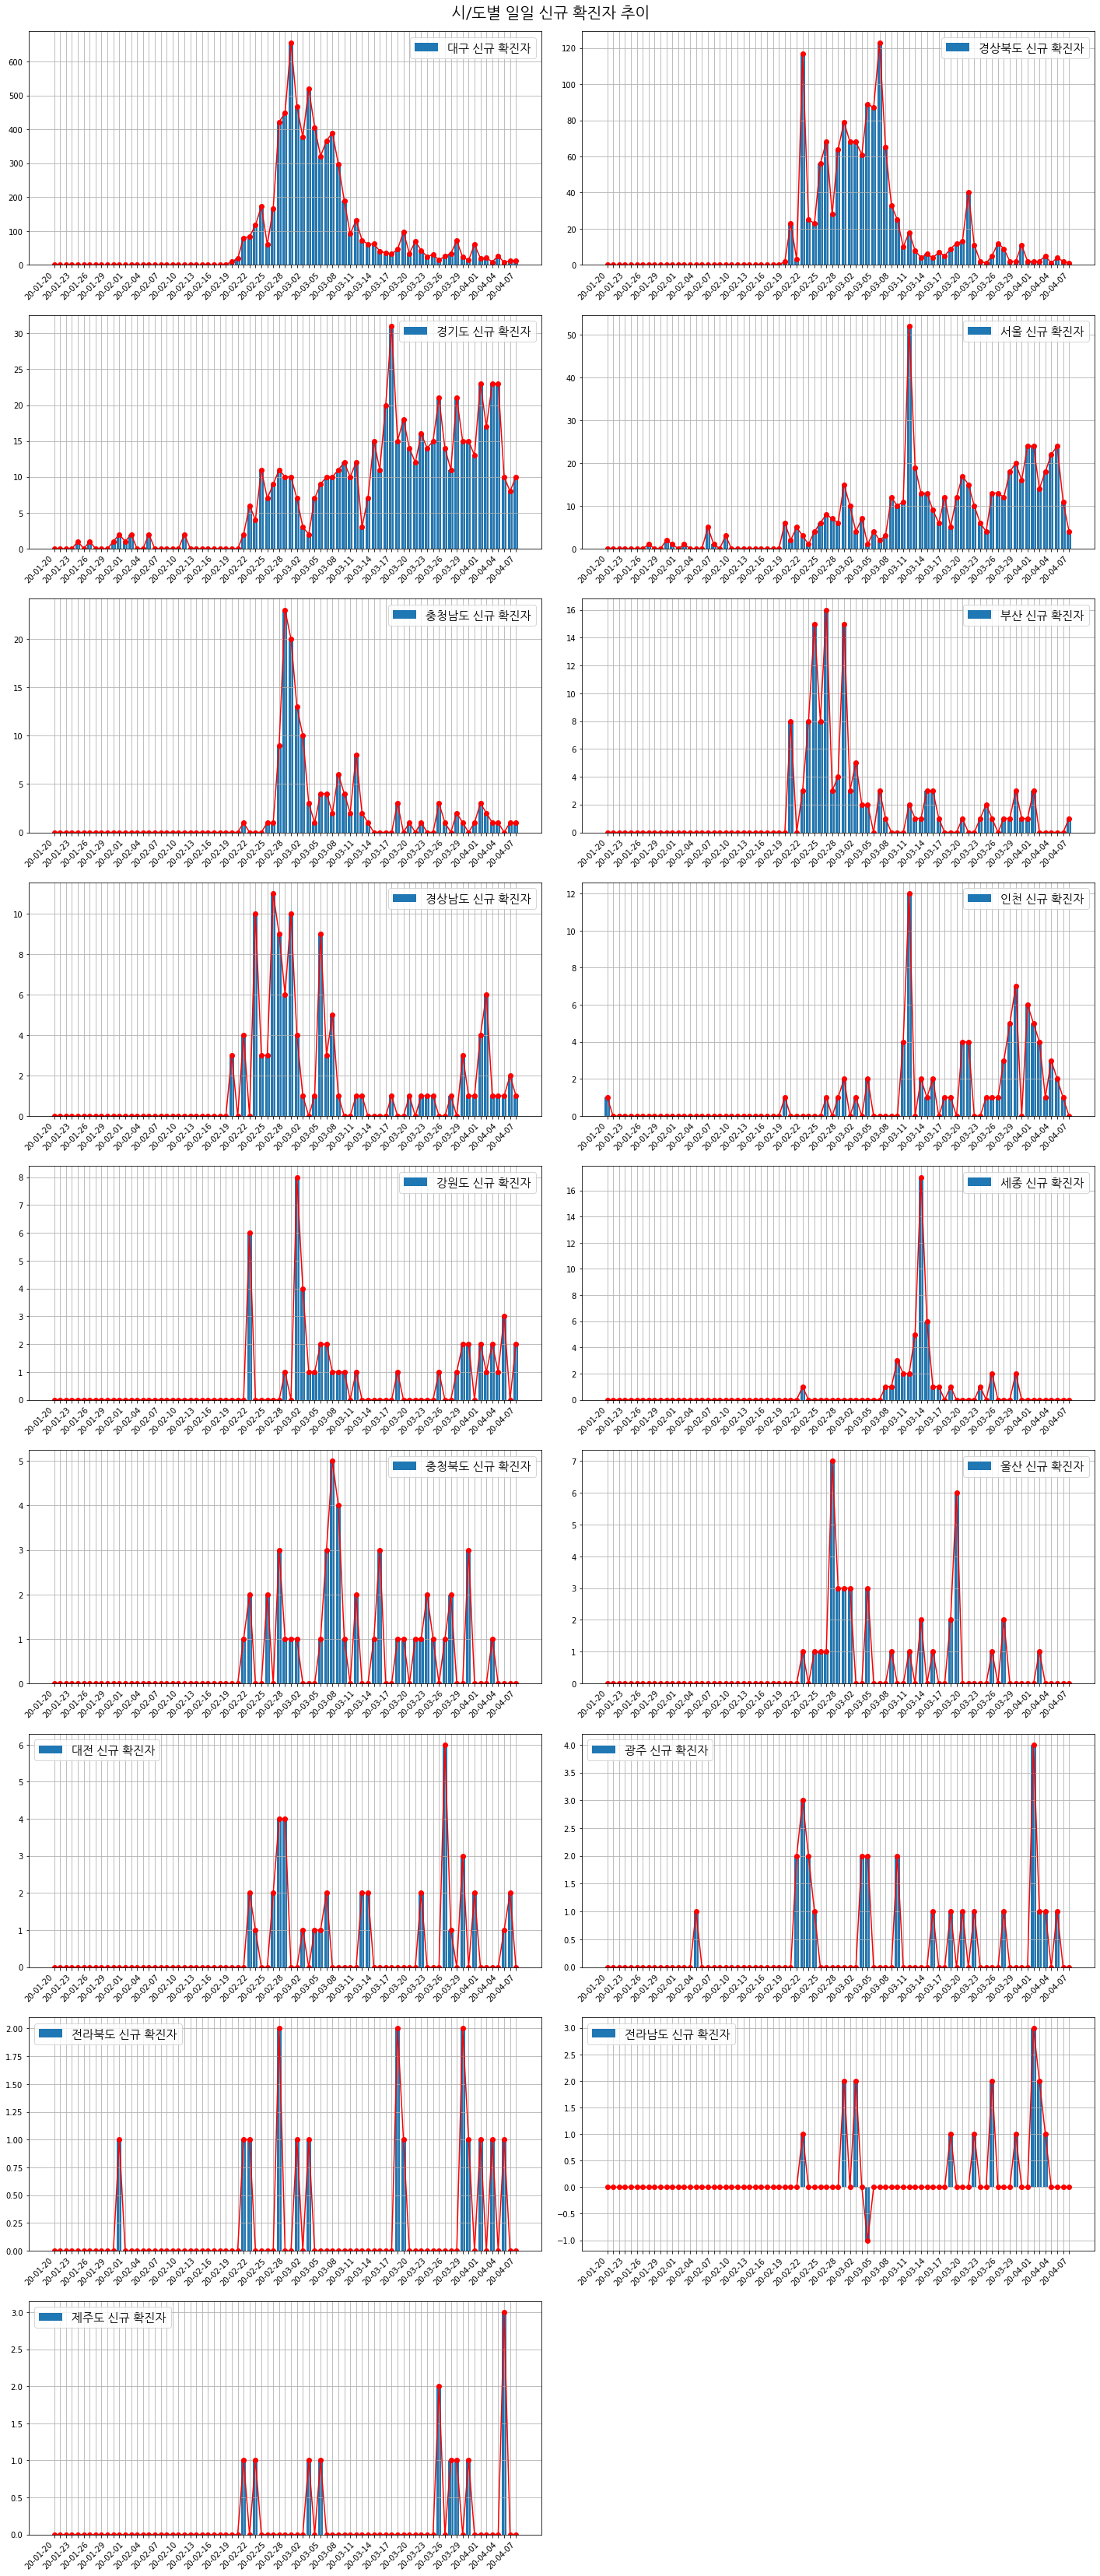

In [13]:
# 시/도별 신규 확진자 추이 그래프
font_path =  '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
cities = TimeProvince_df.sort_values('confirmed', ascending=False).province.unique()

fig = plt.figure(figsize=(20, 5*len(cities)//2 +5))
for idx, city in enumerate(cities):
    tmp_ax = plt.subplot(len(cities)//2 +1, 2, idx+1)
    tmp_df = TimeProvince_df[TimeProvince_df.province==city]
    
    tmp_ax.bar(tmp_df.date, tmp_df.new_confirmed, label=f'{city} 신규 확진자')
    tmp_ax.plot(tmp_df.date, tmp_df.new_confirmed, 'o-r')
    
    # x축 구간 및 라벨 설정
    plt.xticks(tmp_df.date, rotation=45, horizontalalignment='right')
    tmp_xticks_labels = [ date.strftime('%y-%m-%d') if idx%3==0 else '' for idx, date in enumerate(tmp_df.date) ]
    tmp_ax.set_xticklabels(tmp_xticks_labels)
    
    tmp_ax.legend(prop=fm.FontProperties(fname=font_path, size=15))
    plt.grid()
    pass

plt.suptitle('시/도별 일일 신규 확진자 추이', fontproperties=fm.FontProperties(fname=font_path, size=20))
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.97)

plt.show()